# A/B тестирование

Необходимо приоритизировать гипотезы, которые могут повысить выручку интернет-магазина, и проанализировать результаты А/В теста

1. [Часть 1. Приоритизация гипотез](#step1)
2. [Часть 2. Анализ A/B-теста](#step2)
    * [Подготовка данных](#prepare_data)
    * [Расчет кумулятивных метрик](#cumulative)
    * [Определение аномальных значений](#abnormal)
    * [Статистическая проверка гипотез](#stats)
3. [Часть 3. Выводы и рекомендации](#step3)


**Описание данных**

Файл /datasets/hypothesis.csv. 

`Hypothesis` — краткое описание гипотезы;

`Reach` — охват пользователей по 10-балльной шкале;

`Impact` — влияние на пользователей по 10-балльной шкале;

`Confidence` — уверенность в гипотезе по 10-балльной шкале;

`Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv

`transactionId` — идентификатор заказа;

`visitorId` — идентификатор пользователя, совершившего заказ;

`date` — дата, когда был совершён заказ;

`revenue` — выручка заказа;

`group` — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv

`date` — дата;

`group` — группа A/B-теста;

`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

# Часть 1. Приоритизация гипотез <a name="step1"></a>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
pd.plotting.register_matplotlib_converters()
import re
import math as mth

In [2]:
#функция для просмотра информации о таблице
def show_info(df):
    display(df.name)
    display(df.head())
    display(df.info())
    print('Количество дубликатов ', df.duplicated().sum())


In [3]:
hypotheses = pd.read_csv('/datasets/hypothesis.csv')
hypotheses.name = 'hypotheses'

In [4]:
show_info(hypotheses)

'hypotheses'

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

Количество дубликатов  0


In [5]:
#приведем названия колонок к нижнему регистру
hypotheses = hypotheses.rename(columns=lambda x: str.lower(x))
hypotheses.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [6]:
#рассчитаем параметры ICE и RICE
hypotheses['ice'] = (hypotheses['impact'] * hypotheses['confidence']) / hypotheses['efforts']
hypotheses['rice'] = (hypotheses['reach'] 
                      * hypotheses['impact'] 
                      * hypotheses['confidence']) / hypotheses['efforts']
hypotheses.index += 1 
display(hypotheses.\
            style.\
            background_gradient(subset = ['ice', 'rice'], cmap ='coolwarm'))

,hypothesis,reach,impact,confidence,efforts,ice,rice
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3333,40
2,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2,4
3,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7,56
4,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125,9
5,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1,3
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33333,4
7,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8,40
8,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112
9,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2


In [7]:
#выведем топ-5 гипотез по обеим метрикам

display(hypotheses[['hypothesis', 'ice']]
            .round(1)\
            .sort_values(by='ice', ascending = False)
            .reset_index()\
            .rename(columns = {'index':'hypothesis_id'})\
            .head())
display(hypotheses[['hypothesis', 'rice']]
            .round(1)\
            .sort_values(by='rice', ascending = False)
            .reset_index()\
            .rename(columns = {'index':'hypothesis_id'})\
            .head())
            

,hypothesis_id,hypothesis,ice
0,9,"Запустить акцию, дающую скидку на товар в день...",16.2
1,1,"Добавить два новых канала привлечения трафика,...",13.3
2,8,Добавить форму подписки на все основные страни...,11.2
3,7,Показать на главной странице баннеры с актуаль...,8.0
4,3,Добавить блоки рекомендаций товаров на сайт ин...,7.0


,hypothesis_id,hypothesis,rice
0,8,Добавить форму подписки на все основные страни...,112.0
1,3,Добавить блоки рекомендаций товаров на сайт ин...,56.0
2,1,"Добавить два новых канала привлечения трафика,...",40.0
3,7,Показать на главной странице баннеры с актуаль...,40.0
4,9,"Запустить акцию, дающую скидку на товар в день...",16.2


## Вывод

Пятерка самых приоритетных гипотез одинакова при использовании обоих методов ранжирования, однако их порядок меняется. Из-за высокого охвата пользователей (reach = 10) гипотеза 8 поднялась на первое место при использовании метода RICE. Гипотеза 9 при учете этого параметра опустилась с первого места на пятое. При этом гипотезы 8 и 1 входят в тройку самых приоритетных при использовании обоих методов ранжирования

# Часть 2. Анализ А/В теста  <a name="step2"></a>

#### Подготовка данных <a name="prepare_data"></a>

In [8]:
orders = pd.read_csv('/datasets/orders.csv')
orders.name = 'orders'
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.name = 'visitors'

In [9]:
for df in [orders, visitors]:
    show_info(df)

'orders'

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

Количество дубликатов  0


'visitors'

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Количество дубликатов  0


In [10]:
#переведем названия столбцов в более читаемый вид, изменим формат столбца с датой
orders = orders\
   .rename(columns=lambda x: re.sub('(.)([A-Z][a-z]+)', r'\1_\2', x).lower())\
   .assign(date = pd.to_datetime(orders['date']))

visitors['date'] = pd.to_datetime(visitors['date'])
display(orders.info())
display(visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1197 non-null int64
visitor_id        1197 non-null int64
date              1197 non-null datetime64[ns]
revenue           1197 non-null int64
group             1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

In [11]:
#разделим заказы  и визиты по группам
orders = orders.sort_values(['group', 'date'])
orders_a = orders[orders['group'] == 'A'].reset_index(drop=True)
orders_b = orders[orders['group'] == 'B'].reset_index(drop=True)

visitors = visitors.sort_values(['group', 'date'])
visitors_a = visitors.loc[visitors['group'] == 'A'].reset_index(drop=True)
visitors_b = visitors.loc[visitors['group'] == 'B'].reset_index(drop=True)

print(orders_a.shape[0])
print(orders_b.shape[0])

557
640


Проверим, что каждый пользователь входит только в одну группу

In [12]:
#покупатели групп А и B
users_a = pd.Series(orders_a['visitor_id'].unique())
users_b = pd.Series(orders_b['visitor_id'].unique())

#найдем пересечение
users_common = pd.Series(np.intersect1d(users_a, users_b))
display(users_common.head())
print('Количество пользователей в группе А -',users_a.shape[0])
print('Количество пользователей в группе B -',users_b.shape[0])
print('Пользователи, попавшие в обе группы - ',users_common.shape[0] )

0      8300375
1    199603092
2    232979603
3    237748145
4    276558944
dtype: int64

Количество пользователей в группе А - 503
Количество пользователей в группе B - 586
Пользователи, попавшие в обе группы -  58


Пользователи не должны попадать в две группы, иначе это искажает результат. Так как в результатах теста таких пользователей довольно много (около 5% от общего количества), то скорее всего это не единичный случай, а ошибка в сплитировании аудитории. Данные и методику проведения теста необходимо перепроверить. И еще мы не знаем, нет ли пересекающихся пользователей среди остальных посетителей, не совершавших заказ, что также может повлиять на резульат.

Для анализа имеющихся данных, таких пользователей следует исключить, также их следует исключить из общего числа посетителей.  

Рассчитаем по дням, сколько пользователей из списка дублирующихся пользовались сервисом в каждой из групп. Далее вычтем это значение из количества визитов

In [13]:
num_duplicated_users_a = orders_a[orders_a['visitor_id'].isin(users_common.to_list())]\
                        .groupby(['date'])\
                        .agg(num_duplicated_users = pd.NamedAgg(column = 'visitor_id', aggfunc = pd.Series.nunique))\
                        .reset_index()


num_duplicated_users_b = orders_b[orders_b['visitor_id'].isin(users_common.to_list())]\
                        .groupby(['date'])\
                        .agg(num_duplicated_users = pd.NamedAgg(column = 'visitor_id', aggfunc = pd.Series.nunique))\
                        .reset_index()

display(num_duplicated_users_a.head())
display(num_duplicated_users_b.head())

,date,num_duplicated_users
0,2019-08-01,1
1,2019-08-02,1
2,2019-08-04,4
3,2019-08-05,3
4,2019-08-06,3


,date,num_duplicated_users
0,2019-08-01,3
1,2019-08-02,1
2,2019-08-03,2
3,2019-08-04,3
4,2019-08-05,2


In [14]:
#скорректируем количество визитов с учетом удаления пересекающихся пользователей
visitors_a = visitors_a\
                .assign(visitors_all = lambda x: x['visitors'])\
                .merge(num_duplicated_users_a, on = 'date', how = 'left')\
                .fillna(0)\
                .assign(visitors_unique = lambda x: x['visitors'] - x['num_duplicated_users'])

visitors_a['visitors'] = visitors_a['visitors_unique'].astype(int)

visitors_b = visitors_b\
                .assign(visitors_all = lambda x: x['visitors'])\
                .merge(num_duplicated_users_b, on = 'date', how = 'left')\
                .fillna(0)\
                .assign(visitors_unique = lambda x: x['visitors'] - x['num_duplicated_users'])

visitors_b['visitors'] = visitors_b['visitors_unique'].astype(int)

display(visitors_a.head())
display(visitors_b.head())

,date,group,visitors,visitors_all,num_duplicated_users,visitors_unique
0,2019-08-01,A,718,719,1.0,718.0
1,2019-08-02,A,618,619,1.0,618.0
2,2019-08-03,A,507,507,0.0,507.0
3,2019-08-04,A,713,717,4.0,713.0
4,2019-08-05,A,753,756,3.0,753.0


,date,group,visitors,visitors_all,num_duplicated_users,visitors_unique
0,2019-08-01,B,710,713,3.0,710.0
1,2019-08-02,B,580,581,1.0,580.0
2,2019-08-03,B,507,509,2.0,507.0
3,2019-08-04,B,767,770,3.0,767.0
4,2019-08-05,B,705,707,2.0,705.0


In [15]:
#удалим пересекающихся пользователей из обеих групп и посмотрим, сколько покупателей осталось в каждой из них

orders_a = orders_a[~orders_a['visitor_id'].isin(users_common.to_list())]
orders_b = orders_b[~orders_b['visitor_id'].isin(users_common.to_list())]
groups_summary = pd.DataFrame({'group':['A','B']
                                , 'n_buyers':[orders_a.shape[0],orders_b.shape[0]]
                                , 'n_visitors':[visitors_a['visitors'].sum(), visitors_b['visitors'].sum()]})
display(groups_summary)


,group,n_buyers,n_visitors
0,A,468,18650
1,B,548,18832


### Вывод
Есть покупатели, попавшие в обе группы теста, что мешает его интерпретации. Для анализа имеющихся данных эти пользователи были исключены, а методику получения данных необходимо перепроверить. Количество посетителей одинаковое в обеих группах.

#### Расчет кумулятивных метрик <a name="cumulative"></a>

*Кумулятивная выручка по группам*

In [16]:
#посчитаем накопительные значения выруки, количества уникальных покупателей и количества заказов
orders_a['cum_revenue'] = orders_a\
                            .expanding()['revenue']\
                            .apply(sum, raw = False)
orders_a['cum_unique_buyers'] = orders_a\
                                .expanding()['visitor_id']\
                                .apply(lambda x: pd.Series(x).nunique(), raw = False)\
                                .astype(int)
orders_a['cum_orders_count'] = orders_a\
                                .expanding()['transaction_id']\
                                .apply(lambda x: pd.Series(x).count(), raw = False)\
                                .astype(int)
display(orders_a.head())

orders_b['cum_revenue'] = orders_b\
                            .expanding()['revenue']\
                            .apply(sum, raw = False)
orders_b['cum_unique_buyers'] = orders_b\
                                .expanding()['visitor_id']\
                                .apply(lambda x: pd.Series(x).nunique(), raw = False)\
                                .astype(int)
orders_b['cum_orders_count'] = orders_b\
                                .expanding()['transaction_id']\
                                .apply(lambda x: pd.Series(x).count(), raw = False)\
                                .astype(int)
display(orders_b.head())

,transaction_id,visitor_id,date,revenue,group,cum_revenue,cum_unique_buyers,cum_orders_count
0,1144701458,1143609305,2019-08-01,2750,A,2750.0,1,1
1,477940151,1422773200,2019-08-01,700,A,3450.0,2,2
2,1295850747,2947100995,2019-08-01,29499,A,32949.0,3,3
3,1170105516,2706377257,2019-08-01,9024,A,41973.0,4,4
4,1962247337,2706377257,2019-08-01,7129,A,49102.0,4,5


,transaction_id,visitor_id,date,revenue,group,cum_revenue,cum_unique_buyers,cum_orders_count
0,4919758,1217561296,2019-08-01,2350,B,2350.0,1,1
1,3574407166,2328378067,2019-08-01,8999,B,11349.0,2,2
3,2012801741,414545763,2019-08-01,5555,B,16904.0,3,3
4,804934578,1738775963,2019-08-01,3240,B,20144.0,4,4
5,2951399376,2019355024,2019-08-01,2550,B,22694.0,5,5


In [17]:
#рассчитаем накопительные значения для каждого дня
orders_a_cumulative = orders_a\
                        .groupby(['date', 'group'])\
                        .agg(cum_unique_buyers_count = ('cum_unique_buyers','max'),
                             cum_revenue = ('cum_revenue', 'max'),
                             cum_orders_count = ('cum_orders_count', 'max'))\
                        .reset_index()\
                        .assign(cum_avg_cheque = lambda x: x['cum_revenue'] / x['cum_orders_count'])

orders_b_cumulative = orders_b\
                        .groupby(['date', 'group'])\
                        .agg(cum_unique_buyers_count = ('cum_unique_buyers','max'),
                             cum_revenue = ('cum_revenue', 'max'),
                             cum_orders_count = ('cum_orders_count', 'max'))\
                        .reset_index()\
                        .assign(cum_avg_cheque = lambda x: x['cum_revenue'] / x['cum_orders_count'])

display(orders_a_cumulative.head())
display(orders_b_cumulative.head())

,date,group,cum_unique_buyers_count,cum_revenue,cum_orders_count,cum_avg_cheque
0,2019-08-01,A,19,142779.0,23,6207.782609
1,2019-08-02,A,36,234381.0,42,5580.500000
2,2019-08-03,A,60,346854.0,66,5255.363636
3,2019-08-04,A,71,388030.0,77,5039.350649
4,2019-08-05,A,92,474413.0,99,4792.050505


,date,group,cum_unique_buyers_count,cum_revenue,cum_orders_count,cum_avg_cheque
0,2019-08-01,B,17,59758.0,17,3515.176471
1,2019-08-02,B,39,221801.0,40,5545.025000
2,2019-08-03,B,53,288850.0,54,5349.074074
3,2019-08-04,B,66,385740.0,68,5672.647059
4,2019-08-05,B,87,475648.0,89,5344.359551


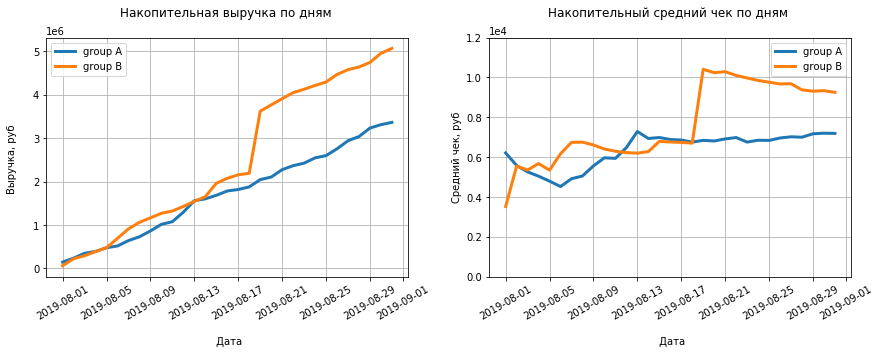

In [18]:
titles = ['Накопительная выручка по дням \n','Накопительный средний чек по дням \n']
ylabels = ['Выручка, руб \n','Средний чек, руб']

fig, ax = plt.subplots(1,2, figsize = (13,5))
fig.tight_layout(pad=5.0)
num = 0

for col in ['cum_revenue','cum_avg_cheque']:
    ax[num].plot(orders_a_cumulative['date'], orders_a_cumulative[col], label = 'group A', lw=3)
    ax[num].plot(orders_b_cumulative['date'], orders_b_cumulative[col], label = 'group B', lw=3)
    ax[num].legend()
    ax[num].grid(True)
    ax[num].set_title(titles[num])
    ax[num].tick_params('x', labelrotation=30)
    ax[num].set_ylabel(ylabels[num])
    ax[num].set_xlabel('\n Дата')
    ax[num].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    num +=1
ax[1].set_ylim(0,12000)    
plt.show()

На графиках накопительных значений выручки и среднего чека виден скачок значений для группы В, что скорее всего определяется выбросами в исходных данных

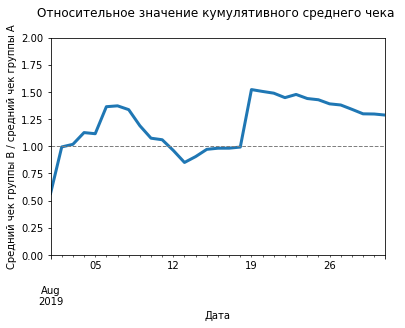

In [19]:
pd.merge(orders_a_cumulative
             , orders_b_cumulative
             , on = 'date'
             , how = 'outer'
             , suffixes=('_a', '_b'))\
        .assign(avg_cheque_relative = lambda x: x['cum_avg_cheque_b'] / x['cum_avg_cheque_a'])\
        .plot('date', 'avg_cheque_relative', lw = 3, legend=None)
plt.ylim(0,2)
plt.axhline(y=1, color = 'grey', linestyle = 'dashed', lw = 1)
plt.title('Относительное значение кумулятивного среднего чека \n')
plt.ylabel('Средний чек группы В / средний чек группы А')
plt.xlabel('Дата')
plt.show()

В группе В средний чек выше, чем в группе А, но большой вклад вносят аномальные значения, имеющиеся в группе В. Необходимо сделать расчет, исключив эти значения

Рассчитаем кумулятивную конверсию по группам как отношение количества людей, совершивших целевое действие(покупку) к общему чисул посетителей

In [20]:

visitors_a['cum_visitors'] = visitors_a\
                        .expanding()['visitors']\
                        .apply(sum, raw = True)\
                        .astype(int)

visitors_b['cum_visitors'] = visitors_b\
                        .expanding()['visitors']\
                        .apply(sum, raw = True)\
                        .astype(int)

display(visitors_a.head())
display(visitors_b.head())

orders_a_cumulative = orders_a_cumulative\
                            .merge(visitors_a, on = ['date','group'], how = 'left')\
                            .assign(cum_conversion = lambda x: x['cum_unique_buyers_count'] / x['cum_visitors'])

orders_b_cumulative = orders_b_cumulative\
                            .merge(visitors_b, on = ['date','group'], how = 'left')\
                            .assign(cum_conversion = lambda x: x['cum_unique_buyers_count'] / x['cum_visitors'])

display(orders_a_cumulative.head())
display(orders_b_cumulative.head())

,date,group,visitors,visitors_all,num_duplicated_users,visitors_unique,cum_visitors
0,2019-08-01,A,718,719,1.0,718.0,718
1,2019-08-02,A,618,619,1.0,618.0,1336
2,2019-08-03,A,507,507,0.0,507.0,1843
3,2019-08-04,A,713,717,4.0,713.0,2556
4,2019-08-05,A,753,756,3.0,753.0,3309


,date,group,visitors,visitors_all,num_duplicated_users,visitors_unique,cum_visitors
0,2019-08-01,B,710,713,3.0,710.0,710
1,2019-08-02,B,580,581,1.0,580.0,1290
2,2019-08-03,B,507,509,2.0,507.0,1797
3,2019-08-04,B,767,770,3.0,767.0,2564
4,2019-08-05,B,705,707,2.0,705.0,3269


,date,group,cum_unique_buyers_count,cum_revenue,cum_orders_count,cum_avg_cheque,visitors,visitors_all,num_duplicated_users,visitors_unique,cum_visitors,cum_conversion
0,2019-08-01,A,19,142779.0,23,6207.782609,718,719,1.0,718.0,718,0.026462
1,2019-08-02,A,36,234381.0,42,5580.500000,618,619,1.0,618.0,1336,0.026946
2,2019-08-03,A,60,346854.0,66,5255.363636,507,507,0.0,507.0,1843,0.032556
3,2019-08-04,A,71,388030.0,77,5039.350649,713,717,4.0,713.0,2556,0.027778
4,2019-08-05,A,92,474413.0,99,4792.050505,753,756,3.0,753.0,3309,0.027803


,date,group,cum_unique_buyers_count,cum_revenue,cum_orders_count,cum_avg_cheque,visitors,visitors_all,num_duplicated_users,visitors_unique,cum_visitors,cum_conversion
0,2019-08-01,B,17,59758.0,17,3515.176471,710,713,3.0,710.0,710,0.023944
1,2019-08-02,B,39,221801.0,40,5545.025000,580,581,1.0,580.0,1290,0.030233
2,2019-08-03,B,53,288850.0,54,5349.074074,507,509,2.0,507.0,1797,0.029494
3,2019-08-04,B,66,385740.0,68,5672.647059,767,770,3.0,767.0,2564,0.025741
4,2019-08-05,B,87,475648.0,89,5344.359551,705,707,2.0,705.0,3269,0.026614


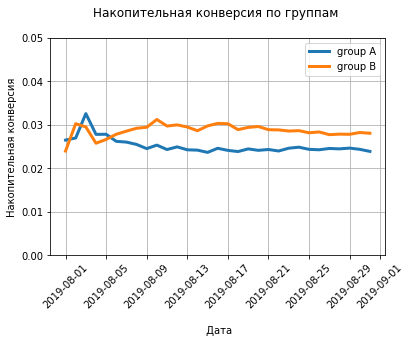

In [21]:
plt.plot(orders_a_cumulative['date'], orders_a_cumulative['cum_conversion'], label = 'group A', lw=3)
plt.plot(orders_b_cumulative['date'], orders_b_cumulative['cum_conversion'], label = 'group B', lw=3)
plt.grid(True)
plt.xticks(rotation = 45)
plt.ylim(0.0,0.05)
plt.title('Накопительная конверсия по группам \n')
plt.ylabel('Накопительная конверсия')
plt.xlabel('\n Дата')
plt.legend()
plt.show()  

Кумулятивное значение конверсии быстро стабилизируется, и группа В демонстрирует лучшую конверсию, чем группа А. Рассчитаем относительное значение:

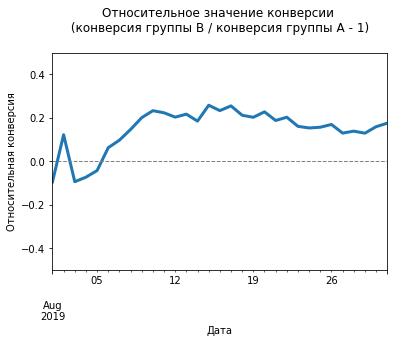

In [22]:
pd.merge(orders_a_cumulative
             , orders_b_cumulative
             , on = 'date'
             , how = 'outer'
             , suffixes=('_a', '_b'))\
        .assign(cum_сonversion_relative = lambda x: x['cum_conversion_b'] / x['cum_conversion_a'] - 1)\
        .plot('date', 'cum_сonversion_relative', lw = 3, legend=None)
plt.ylim(-0.5,0.5)
plt.axhline(y=0, color = 'grey', linestyle = 'dashed', lw = 1)
plt.title('Относительное значение конверсии \n (конверсия группы В / конверсия группы А - 1) \n')
plt.ylabel('Относительная конверсия')
plt.xlabel('Дата')
plt.show()

#### Определение аномальных значений <a name="abnormal"></a>

Рассчитаем количество заказов по пользователям, чтобы определить аномалии

In [23]:
orders_per_user_a = orders_a\
                        .groupby(['visitor_id'])\
                        .agg(orders_per_user = pd.NamedAgg(column = 'transaction_id', aggfunc = 'count'))

orders_per_user_b = orders_b\
                        .groupby(['visitor_id'])\
                        .agg(orders_per_user = pd.NamedAgg(column = 'transaction_id', aggfunc = 'count'))


display(orders_per_user_a.sort_values(by = 'orders_per_user', ascending = False).head())
display(orders_per_user_b.sort_values(by = 'orders_per_user', ascending = False).head())

,orders_per_user
visitor_id,
611059232,3
2108163459,3
2988190573,3
3908431265,3
3967698036,3


,orders_per_user
visitor_id,
2742574263,3
249864742,3
3935952912,2
2025197455,2
3332057097,2


In [24]:
revenue_per_order_a = orders_a.filter(['transaction_id','revenue'])
revenue_per_order_b = orders_b.filter(['transaction_id','revenue'])

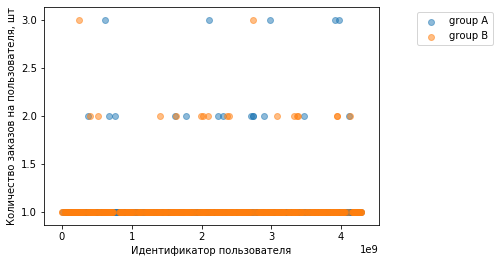

Перцентиль 90
Группа А: 1.0
Группа B: 1.0

Перцентиль 95
Группа А: 1.0
Группа B: 1.0

Перцентиль 99
Группа А: 2.6
Группа B: 2.0



In [25]:
plt.scatter(orders_per_user_a.index, orders_per_user_a, label = 'group A', alpha = .5)
plt.scatter(orders_per_user_b.index, orders_per_user_b, label = 'group B', alpha = .5)
plt.legend(bbox_to_anchor = (1.1,1))
plt.ylabel('Количество заказов на пользователя, шт')
plt.xlabel('Идентификатор пользователя')
plt.show()
for perc in [90,95,99]:
    print('Перцентиль', perc)
    print('Группа А:',np.percentile(orders_per_user_a['orders_per_user'], perc).round(1))
    print('Группа B:',np.percentile(orders_per_user_b['orders_per_user'], perc).round(1))
    print()

Аномальных значений по количеству заказов нет. Проверим стоимость заказов

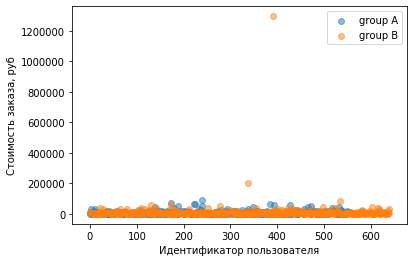

Перцентиль 90
Группа А: 17990.0
Группа B: 17990.0

Перцентиль 95
Группа А: 24944.5
Группа B: 27561.5

Перцентиль 99
Группа А: 56064.2
Группа B: 49553.6



In [26]:
plt.scatter(revenue_per_order_a.index, revenue_per_order_a['revenue'], label = 'group A', alpha = .5)
plt.scatter(revenue_per_order_b.index, revenue_per_order_b['revenue'], label = 'group B', alpha = .5)
plt.legend()
plt.ylabel('Стоимость заказа, руб')
plt.xlabel('Идентификатор пользователя')
plt.show()
for perc in [90,95,99]:
    print('Перцентиль', perc)
    print('Группа А:',np.percentile(revenue_per_order_a['revenue'], perc).round(1))
    print('Группа B:',np.percentile(revenue_per_order_b['revenue'], perc).round(1))
    print()

На графике видно, что аномально высокие значения выручки имеют два заказа, их необходимо исключить. Эти заказы, скорее всего, создавали скачок на графиках накопительной выручки и среднего чека. Далее посмотрим это на графиках по очищенным данным. Удалим заказы со стоимостью более 56100 руб и сохраним более 99% заказов. Далее рассчитаем накопительную выручку и средний чек для очищенных данных

In [27]:
#отфильтруем заказы дороже 60000 руб
orders_filtered_a = orders_a[orders_a['revenue'] < 56100].reset_index(drop=True)
orders_filtered_b = orders_b[orders_b['revenue'] < 56100].reset_index(drop=True)

In [28]:
#определим идентификаторы покупателей с аномально дорогими заказами
abnormal_users_a = orders_a[orders_a['revenue'] > 56100]['visitor_id'].to_list()
abnormal_users_b = orders_b[orders_b['revenue'] > 56100]['visitor_id'].to_list()
print(abnormal_users_a, abnormal_users_b)


[4133034833, 148427295, 1164614297, 1307669133, 887908475] [4003628586, 2108080724, 1920142716, 888512513]


In [29]:
#посчитаем накопительные значения
orders_filtered_a['cum_revenue'] = orders_filtered_a\
                            .expanding()['revenue']\
                            .apply(sum, raw = False)
orders_filtered_a['cum_unique_buyers'] = orders_filtered_a\
                                .expanding()['visitor_id']\
                                .apply(lambda x: pd.Series(x).nunique(), raw = False)\
                                .astype(int)
orders_filtered_a['cum_orders_filtered_count'] = orders_filtered_a\
                                .expanding()['transaction_id']\
                                .apply(lambda x: pd.Series(x).count(), raw = False)\
                                .astype(int)

orders_filtered_b['cum_revenue'] = orders_filtered_b\
                            .expanding()['revenue']\
                            .apply(sum, raw = False)
orders_filtered_b['cum_unique_buyers'] = orders_filtered_b\
                                .expanding()['visitor_id']\
                                .apply(lambda x: pd.Series(x).nunique(), raw = False)\
                                .astype(int)
orders_filtered_b['cum_orders_filtered_count'] = orders_filtered_b\
                                .expanding()['transaction_id']\
                                .apply(lambda x: pd.Series(x).count(), raw = False)\
                                .astype(int)

#рассчитаем накопительные значения для каждого дня
orders_filtered_a_cumulative = orders_filtered_a\
                        .groupby(['date', 'group'])\
                        .agg(cum_unique_buyers_count = ('cum_unique_buyers','max'),
                             cum_revenue = ('cum_revenue', 'max'),
                             cum_orders_filtered_count = ('cum_orders_filtered_count', 'max'))\
                        .reset_index()\
                        .assign(cum_avg_cheque = lambda x: x['cum_revenue'] / x['cum_orders_filtered_count'])

orders_filtered_b_cumulative = orders_filtered_b\
                        .groupby(['date', 'group'])\
                        .agg(cum_unique_buyers_count = ('cum_unique_buyers','max'),
                             cum_revenue = ('cum_revenue', 'max'),
                             cum_orders_filtered_count = ('cum_orders_filtered_count', 'max'))\
                        .reset_index()\
                        .assign(cum_avg_cheque = lambda x: x['cum_revenue'] / x['cum_orders_filtered_count'])

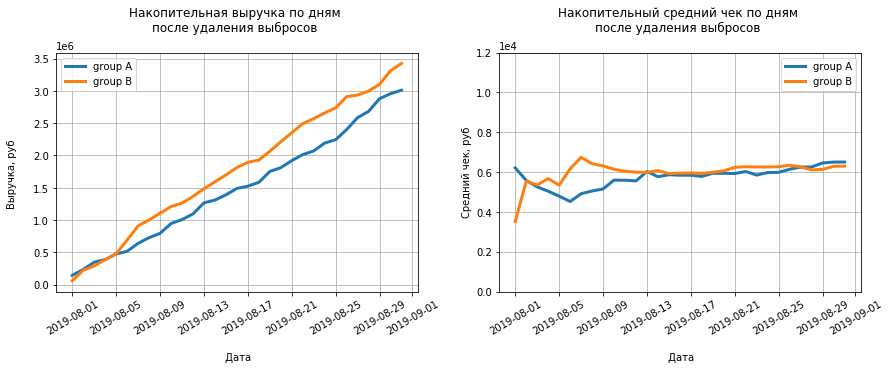

In [30]:
#построим графики по очищенным данным
titles = ['Накопительная выручка по дням \n','Накопительный средний чек по дням \n']
ylabels = ['Выручка, руб \n','Средний чек, руб']

fig, ax = plt.subplots(1,2, figsize = (13,5))
fig.tight_layout(pad=5.0)
num = 0

for col in ['cum_revenue','cum_avg_cheque']:
    ax[num].plot(orders_filtered_a_cumulative['date'], orders_filtered_a_cumulative[col], label = 'group A', lw=3)
    ax[num].plot(orders_filtered_b_cumulative['date'], orders_filtered_b_cumulative[col], label = 'group B', lw=3)
    ax[num].legend()
    ax[num].grid(True)
    ax[num].set_title(titles[num] +  'после удаления выбросов \n')
    ax[num].tick_params('x', labelrotation=30)
    ax[num].set_ylabel(ylabels[num])
    ax[num].set_xlabel('\n Дата')
    ax[num].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    num +=1
ax[1].set_ylim(0,12000)    
plt.show()

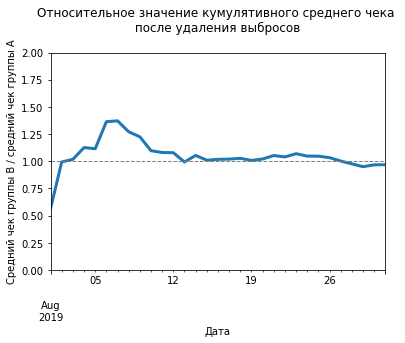

In [31]:
pd.merge(orders_filtered_a_cumulative
             , orders_filtered_b_cumulative
             , on = 'date'
             , how = 'outer'
             , suffixes=('_a', '_b'))\
        .assign(avg_cheque_relative = lambda x: x['cum_avg_cheque_b'] / x['cum_avg_cheque_a'])\
        .plot('date', 'avg_cheque_relative', lw = 3, legend=None)
plt.ylim(0,2)
plt.axhline(y=1, color = 'grey', linestyle = 'dashed', lw = 1)
plt.title('Относительное значение кумулятивного среднего чека \n после удаления выбросов \n')
plt.ylabel('Средний чек группы В / средний чек группы А')
plt.xlabel('Дата')
plt.show()

Судя по графикам средний чек в обеих группах одинаковый. Проверим это статистически в следующем разделе

Рассчитаем конверсию. При общем числе посетителей более 18 тыс, удаление 5 из них не будет влиять на конверсию, поэтому оставим общее число посетителей неизменным

In [32]:
orders_filtered_a_cumulative = orders_filtered_a_cumulative\
                            .merge(visitors_a, on = ['date','group'], how = 'left')\
                            .assign(cum_conversion = lambda x: x['cum_unique_buyers_count'] / x['cum_visitors'])

orders_filtered_b_cumulative = orders_filtered_b_cumulative\
                            .merge(visitors_b, on = ['date','group'], how = 'left')\
                            .assign(cum_conversion = lambda x: x['cum_unique_buyers_count'] / x['cum_visitors'])

display(orders_filtered_a_cumulative.head())
display(orders_filtered_b_cumulative.head())

,date,group,cum_unique_buyers_count,cum_revenue,cum_orders_filtered_count,cum_avg_cheque,visitors,visitors_all,num_duplicated_users,visitors_unique,cum_visitors,cum_conversion
0,2019-08-01,A,19,142779.0,23,6207.782609,718,719,1.0,718.0,718,0.026462
1,2019-08-02,A,36,234381.0,42,5580.500000,618,619,1.0,618.0,1336,0.026946
2,2019-08-03,A,60,346854.0,66,5255.363636,507,507,0.0,507.0,1843,0.032556
3,2019-08-04,A,71,388030.0,77,5039.350649,713,717,4.0,713.0,2556,0.027778
4,2019-08-05,A,92,474413.0,99,4792.050505,753,756,3.0,753.0,3309,0.027803


,date,group,cum_unique_buyers_count,cum_revenue,cum_orders_filtered_count,cum_avg_cheque,visitors,visitors_all,num_duplicated_users,visitors_unique,cum_visitors,cum_conversion
0,2019-08-01,B,17,59758.0,17,3515.176471,710,713,3.0,710.0,710,0.023944
1,2019-08-02,B,39,221801.0,40,5545.025000,580,581,1.0,580.0,1290,0.030233
2,2019-08-03,B,53,288850.0,54,5349.074074,507,509,2.0,507.0,1797,0.029494
3,2019-08-04,B,66,385740.0,68,5672.647059,767,770,3.0,767.0,2564,0.025741
4,2019-08-05,B,87,475648.0,89,5344.359551,705,707,2.0,705.0,3269,0.026614


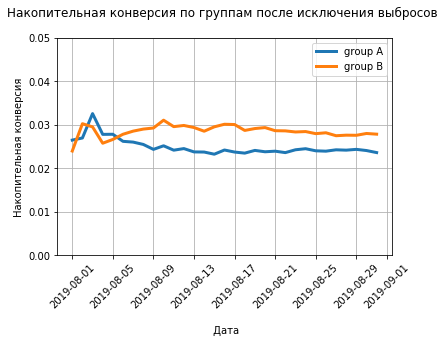

In [33]:
#построим график для кумулятивного значения конверсии по очищенным данным
plt.plot(orders_filtered_a_cumulative['date'], orders_filtered_a_cumulative['cum_conversion'], label = 'group A', lw=3)
plt.plot(orders_filtered_b_cumulative['date'], orders_filtered_b_cumulative['cum_conversion'], label = 'group B', lw=3)
plt.grid(True)
plt.xticks(rotation = 45)
plt.ylim(0.0,0.05)
plt.title('Накопительная конверсия по группам после исключения выбросов \n')
plt.ylabel('Накопительная конверсия')
plt.xlabel('\n Дата')
plt.legend()
plt.show()  

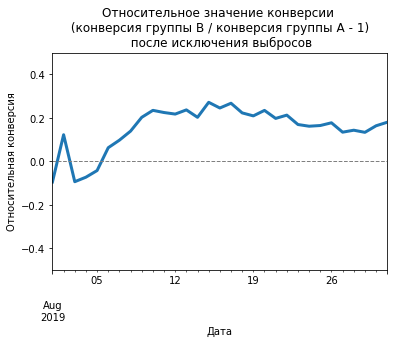

In [34]:
#построим график для кумулятивного относительного значения конверсии по очищенным данным
pd.merge(orders_filtered_a_cumulative
             , orders_filtered_b_cumulative
             , on = 'date'
             , how = 'outer'
             , suffixes=('_a', '_b'))\
        .assign(cum_сonversion_relative = lambda x: x['cum_conversion_b'] / x['cum_conversion_a'] - 1)\
        .plot('date', 'cum_сonversion_relative', lw = 3, legend=None)
plt.ylim(-0.5,0.5)
plt.axhline(y=0, color = 'grey', linestyle = 'dashed', lw = 1)
plt.title('Относительное значение конверсии \n (конверсия группы В / конверсия группы А - 1) \n  после исключения выбросов ')
plt.ylabel('Относительная конверсия')
plt.xlabel('Дата')
plt.show()

### Вывод

Заказы с аномально высокой выручкой были исключены из рассмотрения, что позволило получить гладкие зависимости для кумулятивных метрик, которые далее можно проанализировать статистически. На конверсию в обеих группах это не повлияло


#### Статистическая проверка гипотез <a name="stats"></a>

In [35]:
#возьмем финальные цифры за все время проведения эксперимента, чтобы расчитать конверсию из посетелей в покупателей
#Количетсов аномальных пользователей не превышает 5, при общем числе посетителей более 18 тыс это неважно

conversion_raw = pd.concat([orders_a_cumulative.iloc[-1:].filter(['group','cum_unique_buyers_count','cum_visitors' ])
                           , orders_b_cumulative.iloc[-1:].filter(['group','cum_unique_buyers_count','cum_visitors' ])])\
                    .set_index('group')\
                    .assign(conversion = lambda x: x['cum_unique_buyers_count'] / x['cum_visitors'])
display(conversion_raw)

conversion_filtered = pd.concat([orders_filtered_a_cumulative.iloc[-1:].filter(['group','cum_unique_buyers_count','cum_visitors' ])
                           , orders_filtered_b_cumulative.iloc[-1:].filter(['group','cum_unique_buyers_count','cum_visitors' ])])\
                        .set_index('group')\
                        .assign(conversion = lambda x: x['cum_unique_buyers_count'] / x['cum_visitors'])
display(conversion_filtered)

,cum_unique_buyers_count,cum_visitors,conversion
group,,,
A,445,18650,0.023861
B,528,18832,0.028037


,cum_unique_buyers_count,cum_visitors,conversion
group,,,
A,440,18650,0.023592
B,524,18832,0.027825


Определим статистическую достоверность различия конверсий из посетителей в покупателей. В этом случае конверсия определяется как доля уникальных посетителей, которые совершили хотя бы одну покупку. В этом случае для оценки статистической значимости различия долей можно использовать z-тест. При расчете конверсии как среднего количества заказов на одного посетителя необходимо использовать массивы значений количества заказов для каждого посетителя и сравнивать их при помощи критерия Манна-Уитни. Рассчитаем статистическую значимость изменения обоих параметров между группами

In [36]:
#провериим гипотезу о равенстве долей (отношения количества покупателей к количеству посетителей) для сырых данных

alpha = .05 #уровень значимости

p_a = conversion_raw.at['A','cum_unique_buyers_count'] / conversion_raw.at['A','cum_visitors']
p_b = conversion_raw.at['B','cum_unique_buyers_count'] / conversion_raw.at['B','cum_visitors']
p_combined = (conversion_raw.at['A','cum_unique_buyers_count'] + conversion_raw.at['B','cum_unique_buyers_count'])\
            / (conversion_raw.at['A','cum_visitors'] + conversion_raw.at['B','cum_visitors'])
difference = p_a - p_b

z_value = difference / mth.sqrt(
                        p_combined 
                        * (1 - p_combined) 
                        * (1/conversion_raw.at['A','cum_visitors'] + 1/conversion_raw.at['B','cum_visitors']))

distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2



print('Относительное изменение конверсии {:.3f}'.format(conversion_raw.at['B','conversion'] 
                                                                / conversion_raw.at['A','conversion'] 
                                                                - 1))

print('p-значение: {:.3f}'.format( p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

Относительное изменение конверсии 0.175
p-значение: 0.011
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [37]:
#провериим гипотезу о равенстве долей (отношения количества покупателей к количеству посетителей) для очищенных данных

alpha = .05 #уровень значимости

p_a = conversion_filtered.at['A','cum_unique_buyers_count'] / conversion_filtered.at['A','cum_visitors']
p_b = conversion_filtered.at['B','cum_unique_buyers_count'] / conversion_filtered.at['B','cum_visitors']
p_combined = (conversion_filtered.at['A','cum_unique_buyers_count'] + conversion_filtered.at['B','cum_unique_buyers_count'])\
            / (conversion_filtered.at['A','cum_visitors'] + conversion_filtered.at['B','cum_visitors'])
difference = p_a - p_b

z_value = difference / mth.sqrt(
                        p_combined 
                        * (1 - p_combined) 
                        * (1/conversion_filtered.at['A','cum_visitors'] + 1/conversion_filtered.at['B','cum_visitors']))

distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('Относительное изменение конверсии {:.3f}'.format(conversion_filtered.at['B','conversion'] 
                                                                / conversion_filtered.at['A','conversion'] 
                                                                - 1))

print('p-значение: {:.3f}'.format( p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

Относительное изменение конверсии 0.179
p-значение: 0.010
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [38]:
#проверка гипотезы о равенстве конверсии (среднего количества покупок на посетителя) для сырых данных

#количество заказов для каждого покупателя
orders_by_users_a = orders_a\
                    .groupby('visitor_id')['transaction_id']\
                    .agg(num_orders = pd.NamedAgg(column = 'transaction_id', aggfunc = pd.Series.nunique))
orders_by_users_b = orders_b\
                    .groupby('visitor_id')['transaction_id']\
                    .agg(num_orders = pd.NamedAgg(column = 'transaction_id', aggfunc = pd.Series.nunique))

#массив значений количества заказов для всех посетителей, тем, кто ничего не заказал, соответствует 0
sample_a = pd.concat([orders_by_users_a['num_orders']
                             ,pd.Series(0, index=np.arange(orders_a_cumulative['visitors'].sum() 
                                                                - len(orders_by_users_a['num_orders'])), name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['num_orders']
                             ,pd.Series(0, index=np.arange(orders_b_cumulative['visitors'].sum() 
                                                                - len(orders_by_users_b['num_orders'])), name='orders')],axis=0)

#Примерим критерй Манна-Уитни для сравнения массивов

print("p_value = {0:.3f}".format(st.mannwhitneyu(sample_a, sample_b)[1]))
print("Относительная разница конверсии между группами {0:.3f}".format(sample_b.mean()/sample_a.mean()-1))
p_value = st.mannwhitneyu(sample_a, sample_b)[1]
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")

p_value = 0.006
Относительная разница конверсии между группами 0.160
Отвергаем нулевую гипотезу: между группами есть значимая разница


In [39]:
#проверка гипотезы о равенстве конверсии (среднего количества покупок на посетителя) для очищенных данных

#количество заказов для каждого покупателя
orders_filtered_by_users_a = orders_filtered_a\
                    .groupby('visitor_id')['transaction_id']\
                    .agg(num_orders_filtered = pd.NamedAgg(column = 'transaction_id', aggfunc = pd.Series.nunique))
orders_filtered_by_users_b = orders_filtered_b\
                    .groupby('visitor_id')['transaction_id']\
                    .agg(num_orders_filtered = pd.NamedAgg(column = 'transaction_id', aggfunc = pd.Series.nunique))

#массив значений количества заказов для всех посетителей, тем, кто ничего не заказал, соответствуеет 0
sample_filtered_a = pd.concat([orders_filtered_by_users_a['num_orders_filtered']
                             ,pd.Series(0, index=np.arange(orders_filtered_a_cumulative['visitors'].sum() 
                                                                - len(orders_filtered_by_users_a['num_orders_filtered'])), name='orders_filtered')],axis=0)

sample_filtered_b = pd.concat([orders_filtered_by_users_b['num_orders_filtered']
                             ,pd.Series(0, index=np.arange(orders_filtered_b_cumulative['visitors'].sum() 
                                                                - len(orders_filtered_by_users_b['num_orders_filtered'])), name='orders_filtered')],axis=0)

#Примерим критерй Манна-Уитни для сравнения массивов

print("p_value = {0:.3f}".format(st.mannwhitneyu(sample_filtered_a, sample_filtered_b)[1]))
print("Относительная разница конверсии между группами {0:.3f}".format(sample_filtered_b.mean()/sample_filtered_a.mean()-1))
p_value = st.mannwhitneyu(sample_filtered_a, sample_filtered_b)[1]
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")

p_value = 0.005
Относительная разница конверсии между группами 0.164
Отвергаем нулевую гипотезу: между группами есть значимая разница


Таким образом, в группе В достоверно повысилась конверсия по сравнению с группой А

Сравним значения среднего чека между группами. Для этого возьмем массив данных по выручке с каждого заказа и сравним распределения

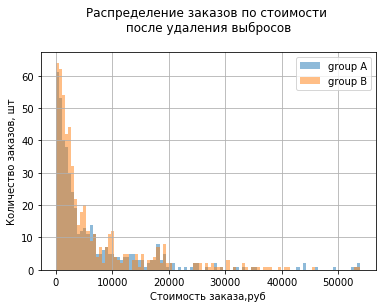

In [40]:
#посмотрим на гистограммы стоимости заказов после очистки данных
orders_filtered_a['revenue'].hist(bins=100, alpha = 0.5, label = 'group A')
orders_filtered_b['revenue'].hist(bins=100, alpha = 0.5, label = 'group B')
plt.title('Распределение заказов по стоимости \n после удаления выбросов \n')
plt.ylabel('Количество заказов, шт')
plt.xlabel('Стоимость заказа,руб')
plt.legend()
plt.show()

Распределение не похоже на нормальное, проверим это формально с помощью метода Шапиро-Уилка

In [41]:
#сравним средний чек для исходных данных

#проверим данные на нормальность
alpha = .05 # критический уровень статистической значимости

results = st.shapiro(orders_a['revenue'])
p_value = results[1]

print('p-значение: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: распределение не нормально, используем критерий Манна-Уитни для сравнения выборок")
else:
    print("Не получилось отвергнуть нулевую гипотезу, всё нормально")

#применим критерий Манна-Уитни для сравнения выборок
print()
print("p_value = {0:.3f}".format(st.mannwhitneyu(orders_a['revenue'], orders_b['revenue'])[1]))
print("Относительная разница для среднего чека между группами {0:.3f}".format(orders_b['revenue'].mean()/orders_a['revenue'].mean()-1))
p_value = st.mannwhitneyu(orders_a['revenue'], orders_b['revenue'])[1]
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")

p-значение:  2.8240222045454137e-31
Отвергаем нулевую гипотезу: распределение не нормально, используем критерий Манна-Уитни для сравнения выборок

p_value = 0.415
Относительная разница для среднего чека между группами 0.287
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


In [42]:
#сравним средний чек для очищенных данных

#проверим данные на нормальность
alpha = .05 # критический уровень статистической значимости

results = st.shapiro(orders_filtered_a['revenue'])
p_value = results[1]

print('p-значение: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: распределение не нормально, используем критерий Манна-Уитни для сравнения выборок")
else:
    print("Не получилось отвергнуть нулевую гипотезу, всё нормально")

#применим критерий Манна-Уитни для сравнения выборок
print()
print("p_value = {0:.3f}".format(st.mannwhitneyu(orders_filtered_a['revenue'], orders_filtered_b['revenue'])[1]))
print("Относительная разница для среднего чека между группами {0:.3f}".format(orders_filtered_b['revenue'].mean()/orders_filtered_a['revenue'].mean()-1))
alpha = .05
p_value = st.mannwhitneyu(orders_filtered_a['revenue'], orders_filtered_b['revenue'])[1]
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")

p-значение:  7.666280903136271e-29
Отвергаем нулевую гипотезу: распределение не нормально, используем критерий Манна-Уитни для сравнения выборок

p_value = 0.450
Относительная разница для среднего чека между группами -0.032
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


### Вывод

В группе А достоверно повысилась конверсия по сравнению с группой В. Средний чек при этом не изменился, но увеличение конверсии привело к увеличению выручки по сравнении с контрольной группой

# Часть 3. Выводы и рекомендации <a name="step3"></a>

* Пятерка самых приоритетных гипотез одинакова при использовании фреймфорков ICE и RICE, однако их порядок меняется. Из-за высокого охвата пользователей (reach = 10) гипотеза 8 `(Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок)` поднялась на первое место при использовании метода RICE. Гипотеза 9 `(Запустить акцию, дающую скидку на товар в день рождения`) при учете этого параметра опустилась с первого места на пятое. При этом гипотезы 8 и 1`(Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей)` входят в тройку самых приоритетных при использовании обоих методов ранжирования, так что именно их стоит проверить в первую очередь.


* Данные с результатами А/В теста указывают на ошибки в его проведении:

    * Есть большая группа покупателей (около 5% от общего числа), попадающая в обе тестовых группы. Это указывает на некорректное разделение трафика посетителей
    * Разница в количестве посетителей между группами составляет около 1%, что допустимо. Но необходимо проверить исходные данные о посетителях, чтобы исключить перемещение пользователей между группами
    * Кроме того для точных расчетов необходимо иметь все данные о посетителях, а не только агреггированные значения по дням. Это позволит рассчитать как полное количество визитов для конверсии визитов в покупки, так и накопительное количество уникальных пользователей. Без этих данных рассчеты не точны
    
    
* Для анализа имеющихся данных были исключены пользователи, попавшие в обе тестовых группы


* В кумулятивных метриках общей выручки и среднего чека присутствуют скачки, вызванные заказами с аномально высокой стоимостью. Чтобы избавиться от этой проблемы из рассмотрения были исключены 1% заказов с максимальной стоимостью. Однако эти выбросы не повлияли на результат


* В группе В статистически достоверно выросла конверсия посетителей в покупателй (на 18% относительно группы А), а также среднее количество заказов на посетителя (на 16% относительно группы А)


* Средний чек при этом сохранился на том же уровне, что в результате дало увеличение выручки


* По результатам анализа имеющихся данных следует принять решение о прекращении теста

    * Следует проанализировать исходные данные по разделению посетителей на группы, чтобы исключить попадание посетителей в обе группы и точно рассчитать количество уникальных посетителей за весь период проведения теста
    * Если по результатам анализа трафика посетителей не будет обнаружено значительное перекрывание групп, и каждый пользователь будет попадать только в одну из них, можно утверждать, что в группе В достоверно выросла конверсия при сохранении среднего чека. Этот результат показывает увеличение выручки в тестовой группе по сравнению с контрольной
    * При обнаружении посетителей, попадающих в обе группы, их необходимо исключить или полностью провести тест заново, если новый размер выборки не позволяет провести статистическую обработку с нужной точностью